In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import urllib.parse
import seaborn as sns
from tqdm import tqdm
import src.data.data_loader as data_loader

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()

def url_decode(url_encoded):
    return urllib.parse.unquote(url_encoded).replace('_', ' ')

embedding = pd.read_csv('data/embeddings.csv')
embedding['article'] = embedding['article'].apply(url_decode)
print(embedding.shape)

(4605, 2)


In [3]:
from collections import Counter
import pandas as pd

# Step 1: Flatten all articles into a single list
all_words = articles['article']
#all_words.add("Christmas")

# Step 2: Remove duplicates to get all unique articles
all_articles = set(all_words)


word_counts = pd.Series(all_words).value_counts()

# Step 4: Create a DataFrame with article words and their counts
all_words_df = pd.DataFrame({
    'article': list(word_counts.keys())
})
print(all_words_df.head())

# Step 5: Map the encoded versions using the embedding dictionary
embedding_dict = dict(zip(embedding['article'], embedding['embedding']))
all_words_df['embedding'] = all_words_df['article'].map(embedding_dict)
print(embedding_dict.get('Christmas'))
print(all_words_df.iloc[-1])

# Display the resulting DataFrame
all_words_df


                                   article
0                        Áedán mac Gabráin
1  One Flew Over the Cuckoo's Nest (novel)
2                             Open cluster
3                           OpenOffice.org
4                                  OpenBSD
[-0.02675670199096203, 0.012088491581380367, 0.009375070221722126, 0.0005913490313105285, -0.016532212495803833, 0.011105367913842201, 0.0006778639508411288, 0.01923776976764202, 0.018954629078507423, 0.04045751690864563, -0.010995258577167988, -0.011412102729082108, -0.023374754935503006, -0.015604143030941486, -0.015604143030941486, -0.02938360907137394, -0.015965932980179787, -0.017192872241139412, 0.036147501319646835, -0.020228758454322815, 0.016044583171606064, -0.0027645444497466087, 0.03001280687749386, 0.043729353696107864, 0.029053278267383575, 0.03111390583217144, 0.00609143590554595, 0.0066773779690265656, -0.033347565680742264, 0.08380934596061707, 0.034008223563432693, 0.02471180260181427, 0.002304442459717393, -0.0214

article  \
0                           Áedán mac Gabráin   
1     One Flew Over the Cuckoo's Nest (novel)   
2                                Open cluster   
3                              OpenOffice.org   
4                                     OpenBSD   
...                                       ...   
4599                                   Flower   
4600                     Floyd Mayweather Jr.   
4601                                 Fluorine   
4602                                    Flute   
4603                                     Zulu   

                                              embedding  
0     [-0.017695948481559753, 0.0280777495354414, -0...  
1     [0.00400448776781559, -0.015244998969137669, -...  
2     [-0.016463065519928932, -0.0027533359825611115...  
3     [-0.008157136850059032, -0.003929744940251112,...  
4     [-0.03637036681175232, -0.01166799757629633, -...  
...                                                 ...  
4599  [-0.0013984930701553822, -0.007762698922306299...  
4600  [0.004392186179757118, 0.03457573801279068, 0....  
4601  [-0.022218061611056328, 0.005154435057193041, ...  
4602  [-0.021057341247797012, -0.025974925607442856,...  
4603  [0.015002809464931488, 0.003967552445828915, 0...  

[4604 rows x 2 columns]

In [4]:
print(all_words.get('Christmas'))

None


/var/folders/9b/zp5p8_495653n52_yn4hbq9h0000gn/T/ipykernel_3233/4060660327.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


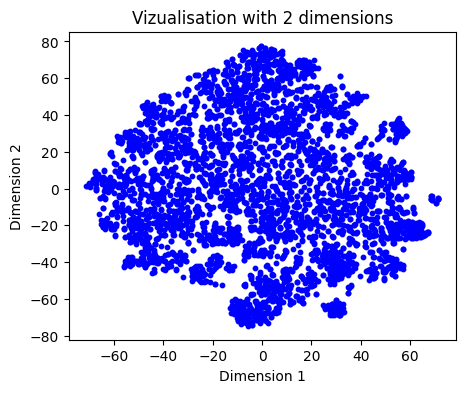

In [5]:
from sklearn.manifold import TSNE

all_words_df['embedding'] = all_words_df['embedding'].apply(
    lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x)
)

# Filter out rows where 'encoded_version' is still invalid (e.g., not arrays)
all_words_df = all_words_df.dropna(subset=['embedding'])
embeddings = np.vstack(all_words_df['embedding'].values)
tsne = TSNE(n_components=2, random_state=42)
tsne3D = TSNE(n_components=3, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)
reduced_embeddings3D = tsne3D.fit_transform(embeddings)

plt.figure(figsize=(5, 4))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c='blue',
    cmap='viridis',
    s=10
)
plt.title(f"Vizualisation with 2 dimensions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

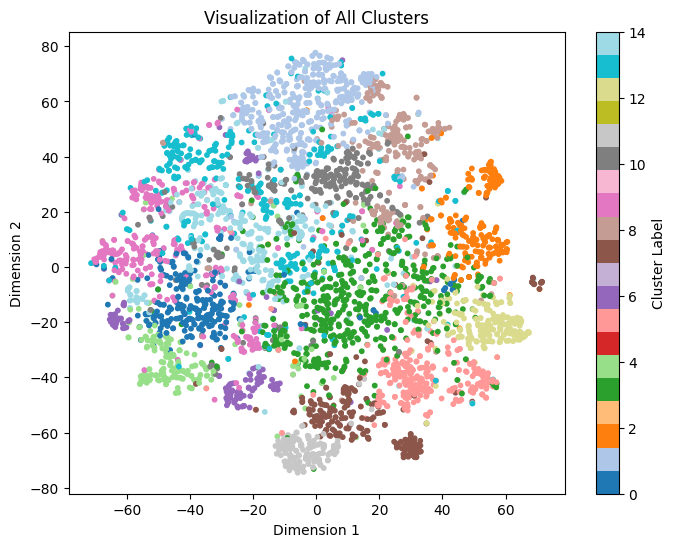

In [6]:
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Step 1: Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Step 2: Fit GMM (Gaussian Mixture Model)
n_components = 15  # Adjust this based on the optimal number of clusters
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(embeddings)

# Assign main theme (cluster) to each data point
all_words_df['main_theme'] = gmm.predict(embeddings)

# Step 3: Visualize all clusters in one graph
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=all_words_df['main_theme'],  # Cluster assignment for each point
    cmap='tab20',  # Use a categorical colormap for distinct cluster colors
    s=10
)
plt.colorbar(label="Cluster Label")
plt.title("Visualization of All Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


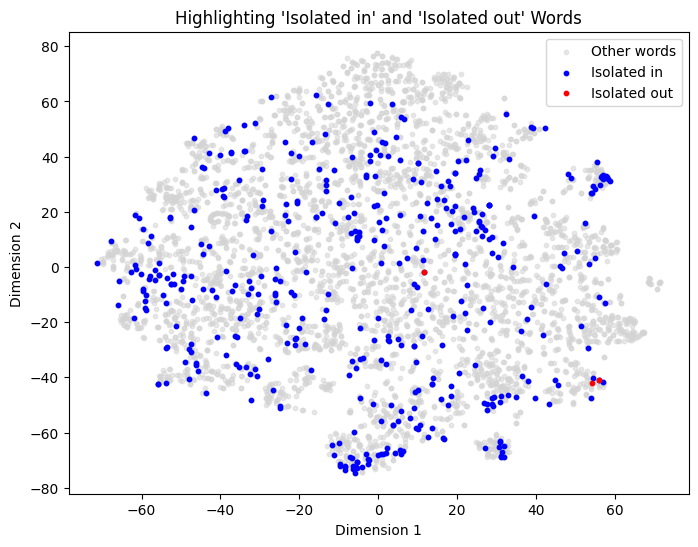

In [7]:
# Load isolated in/out words from files
with open('isolated_in.txt', 'r') as f:
    isolated_in_words = set(f.read().splitlines())
    
with open('isolated_out.txt', 'r') as f:
    isolated_out_words = set(f.read().splitlines())

# Create masks for isolated in/out words
isolated_in_mask = all_words_df['article'].isin(isolated_in_words)
isolated_out_mask = all_words_df['article'].isin(isolated_out_words)

# Create visualization highlighting isolated in/out points
plt.figure(figsize=(8, 6))

# Plot all points in gray first
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c='lightgray',
    s=10,
    alpha=0.5,
    label='Other words'
)

# Highlight isolated in points in blue
plt.scatter(
    reduced_embeddings[isolated_in_mask, 0],
    reduced_embeddings[isolated_in_mask, 1],
    c='blue',
    s=10,
    label='Isolated in'
)

# Highlight isolated out points in red  
plt.scatter(
    reduced_embeddings[isolated_out_mask, 0],
    reduced_embeddings[isolated_out_mask, 1],
    c='red', 
    s=10,
    label='Isolated out'
)

plt.title("Highlighting 'Isolated in' and 'Isolated out' Words")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


In [8]:
# Load isolated in/out words from files
with open('largest_component.txt', 'r') as f:
    largest_component_words = set(f.read().splitlines())

# Create masks for isolated in/out words
isolated_mask = ~all_words_df['article'].isin(largest_component_words)

# Create visualization using plotly
import plotly.express as px
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scatter plots for both groups
fig.add_trace(go.Scatter(
    x=reduced_embeddings[~isolated_mask, 0],
    y=reduced_embeddings[~isolated_mask, 1],
    mode='markers',
    name='Other words',
    marker=dict(
        color='light grey',
        size=5,
        opacity=0.5
    ),
    text=all_words_df[~isolated_mask]['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title="Highlighting Isolated Words",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    hovermode='closest',
    width=800,
    height=600
)

fig.show()


In [9]:
fig.write_html('isolated_words.html')

In [10]:
# Initialize lists to store results
link_article_name_present = []
link_article_absent = []

# Get indices where isolated_mask is True
isolated_indices = np.where(isolated_mask)[0]
# For each isolated word
for idx in isolated_indices:
    # Get the word's embedding
    word_embedding = reduced_embeddings[idx]
    word = all_words_df.iloc[idx]['article']
    
    # Calculate distances to all other words
    distances = np.linalg.norm(reduced_embeddings - word_embedding, axis=1)
    
    # Get indices of 3 nearest neighbors (excluding self) that are in the main component
    nearest_indices = np.argsort(distances)[1:4][~isolated_mask[np.argsort(distances)[1:4]]]  # Skip first as it's the word itself and filter for main component
    neighbors = all_words_df.iloc[nearest_indices]['article'].tolist()
    # Check if neighbors are mentioned in the word's article
    try:
        word_article_path = f"data/plaintext_articles/{urllib.parse.quote(word.replace(' ', '_'))}.txt"
        with open(word_article_path, "r") as f:
            article_text = f.read().lower()
            
        for neighbor in neighbors:
            if neighbor.lower() in article_text:
                link_article_name_present.append((word, neighbor))
            else:
                link_article_absent.append((word, neighbor))
                
    except FileNotFoundError:
        print(f"Article file not found for {word}")

In [11]:
# Convert lists of tuples to DataFrames
present_df = pd.DataFrame(link_article_name_present, columns=['source', 'target'])
absent_df = pd.DataFrame(link_article_absent, columns=['source', 'target'])

# Add a column to identify the type of link
present_df['link_type'] = 'present'
absent_df['link_type'] = 'absent'

# Combine the DataFrames
merged_links_df = pd.concat([present_df, absent_df], ignore_index=True)


In [12]:
# Create a figure for visualizing the links
fig = go.Figure()

# Plot all points
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers',
    name='All Words',
    marker=dict(
        color='lightgray',
        size=5,
        opacity=0.5
    ),
    text=all_words_df['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Add lines for links where words are present in articles
for _, row in present_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target']].index[0]
    
    fig.add_trace(go.Scatter(
        x=[reduced_embeddings[source_idx, 0], reduced_embeddings[target_idx, 0]],
        y=[reduced_embeddings[source_idx, 1], reduced_embeddings[target_idx, 1]],
        mode='lines',
        line=dict(color='green', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

# Add lines for links where words are absent from articles
for _, row in absent_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target']].index[0]
    
    fig.add_trace(go.Scatter(
        x=[reduced_embeddings[source_idx, 0], reduced_embeddings[target_idx, 0]],
        y=[reduced_embeddings[source_idx, 1], reduced_embeddings[target_idx, 1]],
        mode='lines',
        line=dict(color='red', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

# Update layout
fig.update_layout(
    title="Word Embeddings with Links",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    showlegend=True,
    width=800,
    height=600
)

fig.show()


In [13]:
merged_links_df.groupby('link_type')['link_type'].value_counts()

link_type
absent     969
present    231
Name: count, dtype: int64

In [14]:
# Load isolated in/out words from files
with open('largest_component.txt', 'r') as f:
    largest_component_words = set(f.read().splitlines())

# Create masks for isolated in/out words
isolated_mask = ~all_words_df['article'].isin(largest_component_words)

# Create visualization using plotly
import plotly.express as px
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scatter plots for both groups
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers',
    name='Other words',
    marker=dict(
        color='blue',
        size=5,
        opacity=0.5
    ),
    text=all_words_df[:]['article'],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title="Highlighting Words in the embedding space",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    hovermode='closest',
    width=800,
    height=600
)

fig.show()


In [172]:
# Function to create path visualization
def visualize_path(path, reduced_embeddings, all_words_df, target):
    # Create figure
    fig = go.Figure()
    
    # Add all points as background
    fig.add_trace(go.Scatter3d(
        x=reduced_embeddings3D[:, 0],
        y=reduced_embeddings3D[:, 1], 
        z=reduced_embeddings3D[:, 2],
        mode='markers',
        name='All articles',
        marker=dict(
            color='lightgray',
            size=3,
            opacity=0.3
        ),
        text=all_words_df['article'],
        hoverinfo='text'
    ))
    
    # Get indices of path words
    path_indices = []
    target_index = None
    for word in path:
        matches = all_words_df[all_words_df['article'] == word]
        if not matches.empty:
            path_indices.append(matches.index[0])
        else:
            print(f"Warning: Word '{word}' not found in all_words_df")
            return None
    
    target_index = all_words_df[all_words_df['article'] == target].index[0]

    if not path_indices:
        print("No valid words found in path")
        return None
        
    # Add path points
    fig.add_trace(go.Scatter3d(
        x=reduced_embeddings3D[path_indices, 0],
        y=reduced_embeddings3D[path_indices, 1],
        z=reduced_embeddings3D[path_indices, 2],
        mode='markers+lines+text',  # Added text mode
        name='Path',
        marker=dict(
            color='red',
            size=5,
            symbol='circle'
        ),
        line=dict(
            color='red',
            width=2
        ),
        text=[f"{p}" for p in path],
        textposition="top center",  # Position text above points
        hoverinfo='text'
    ))
    
    # Add start point with larger marker
    fig.add_trace(go.Scatter3d(
        x=[reduced_embeddings3D[path_indices[0], 0]],
        y=[reduced_embeddings3D[path_indices[0], 1]],
        z=[reduced_embeddings3D[path_indices[0], 2]],
        mode='markers+text',
        name='Start',
        marker=dict(
            color='green',
            size=8,
            symbol='circle'
        ),
        text=[f"Start: {path[0]}"],
        textfont=dict(
            color='green',
            size=12  # Adjust font size as needed
        ),
        textposition="top center",
        hoverinfo='text'
    ))
    
    # Add end point with larger marker
    fig.add_trace(go.Scatter3d(
        x=[reduced_embeddings3D[target_index, 0]],
        y=[reduced_embeddings3D[target_index, 1]],
        z=[reduced_embeddings3D[target_index, 2]],
        mode='markers+text',
        name='End',
        marker=dict(
            color='blue', 
            size=8,
            symbol='circle'
        ),
        text=[f"Target: {target}"],
        textposition="top center",
        hoverinfo='text'
    ))
    
    # Add arrows using annotations
    for i in range(len(path)-1):
        x1, y1, z1 = reduced_embeddings3D[path_indices[i]]
        x2, y2, z2 = reduced_embeddings3D[path_indices[i+1]]
        
        # Calculate point slightly before target node for arrow placement
        # Move arrow back by 10% of the distance
        xmid = x2 - 0.1 * (x2 - x1)
        ymid = y2 - 0.1 * (y2 - y1) 
        zmid = z2 - 0.1 * (z2 - z1)
        
        # Calculate direction vector
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
        # Add arrow cone just before target node
        fig.add_trace(go.Cone(
            x=[xmid],
            y=[ymid],
            z=[zmid],
            u=[dx],
            v=[dy],
            w=[dz],
            colorscale=[[0, 'red'], [1, 'red']],
            showscale=False,
            sizeref=0.2
        ))
    
    fig.update_layout(
    scene=dict(
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title="",
            backgroundcolor='rgba(0,0,0,0)'
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title="",
            backgroundcolor='rgba(0,0,0,0)'
        ),
        zaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title="",
            backgroundcolor='rgba(0,0,0,0)'
        ),
        bgcolor='rgba(0,0,0,0)'
    ),
    legend=dict(
        yanchor="bottom",
        y=1.1,
        xanchor="center",
        x=0.5,
        orientation="h"
    ),
    showlegend=True,
    width=800,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
    )
    
    return fig

path_id = 1021
example_path = paths_unfinished['traversed'].iloc[path_id]
target = paths_unfinished['target'].iloc[path_id]
print(example_path)
print(target)
fig = visualize_path(example_path, reduced_embeddings3D, all_words_df, target)
fig.show()

['England', 'Atlantic Ocean', 'Bermuda', 'Argentina', 'Uruguay', 'Brazil', 'Venezuela']
Barbados


In [181]:
# Function to create path visualization
def visualize_path(path, reduced_embeddings, all_words_df, target):
    # Create figure if it doesn't exist yet
    if not hasattr(visualize_path, 'fig'):
        visualize_path.fig = go.FigureWidget()
    
    # Clear existing traces
    visualize_path.fig.data = []
    
    # Add all points as background
    visualize_path.fig.add_trace(go.Scatter3d(
        x=reduced_embeddings3D[:, 0],
        y=reduced_embeddings3D[:, 1], 
        z=reduced_embeddings3D[:, 2],
        mode='markers',
        name='All articles',
        marker=dict(
            color='lightgray',
            size=3,
            opacity=0.3
        ),
        text=all_words_df['article'],
        hoverinfo='text'
    ))
    
    # Get indices of path words
    path_indices = []
    target_index = None
    for word in path:
        matches = all_words_df[all_words_df['article'] == word]
        if not matches.empty:
            path_indices.append(matches.index[0])
        else:
            print(f"Warning: Word '{word}' not found in all_words_df")
            return None
    
    target_index = all_words_df[all_words_df['article'] == target].index[0]

    if not path_indices:
        print("No valid words found in path")
        return None
        
    # Add path points
    visualize_path.fig.add_trace(go.Scatter3d(
        x=reduced_embeddings3D[path_indices, 0],
        y=reduced_embeddings3D[path_indices, 1],
        z=reduced_embeddings3D[path_indices, 2],
        mode='markers+lines+text',
        name='Path',
        marker=dict(
            color='red',
            size=5,
            symbol='circle'
        ),
        line=dict(
            color='red',
            width=2
        ),
        text=[f"{p}" for p in path],
        textposition="top center",
        hoverinfo='text'
    ))
    
    # Add start point with larger marker
    visualize_path.fig.add_trace(go.Scatter3d(
        x=[reduced_embeddings3D[path_indices[0], 0]],
        y=[reduced_embeddings3D[path_indices[0], 1]],
        z=[reduced_embeddings3D[path_indices[0], 2]],
        mode='markers+text',
        name='Start',
        marker=dict(
            color='green',
            size=8,
            symbol='circle'
        ),
        text=[f"{path[0]}"],
        textfont=dict(
            color='green',
            size=12
        ),
        textposition="top center",
        hoverinfo='text'
    ))
    
    # Add end point with larger marker
    visualize_path.fig.add_trace(go.Scatter3d(
        x=[reduced_embeddings3D[target_index, 0]],
        y=[reduced_embeddings3D[target_index, 1]],
        z=[reduced_embeddings3D[target_index, 2]],
        mode='markers+text',
        name='End',
        marker=dict(
            color='blue', 
            size=8,
            symbol='circle'
        ),
        text=[f"{target}"],
        textfont=dict(
            color='blue',
            size=12
        ),
        textposition="top center",
        hoverinfo='text'
    ))
    
    # Add arrows using annotations
    for i in range(len(path) - 1):
        # Get start and end points
        x1, y1, z1 = reduced_embeddings3D[path_indices[i]]
        x2, y2, z2 = reduced_embeddings3D[path_indices[i + 1]]
        
        # Midpoint of the arrow
        xmid = x2 - 0.1 * (x2 - x1)
        ymid = y2 - 0.1 * (y2 - y1)
        zmid = z2 - 0.1 * (z2 - z1)
        
        # Direction vector
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
        # Normalize the direction vector to make arrow size consistent
        magnitude = (dx**2 + dy**2 + dz**2)**0.5
        if magnitude > 0:  # Avoid division by zero
            dx_normalized = dx / magnitude
            dy_normalized = dy / magnitude
            dz_normalized = dz / magnitude
        else:
            dx_normalized, dy_normalized, dz_normalized = 0, 0, 0
        
        # Add cone to visualize the arrow
        visualize_path.fig.add_trace(go.Cone(
            x=[xmid],
            y=[ymid],
            z=[zmid],
            u=[dx_normalized],
            v=[dy_normalized],
            w=[dz_normalized],
            colorscale=[[0, 'red'], [1, 'red']],
            showscale=False,
            sizemode="absolute",  # Make size independent of vector length
            sizeref=1  # Adjust for fixed size (tweak as needed)
        ))

    
    visualize_path.fig.update_layout(
        scene=dict(
            xaxis=dict(
                showgrid=False,
                zeroline=False,
                showticklabels=False,
                title="",
                backgroundcolor='rgba(0,0,0,0)'
            ),
            yaxis=dict(
                showgrid=False,
                zeroline=False,
                showticklabels=False,
                title="",
                backgroundcolor='rgba(0,0,0,0)'
            ),
            zaxis=dict(
                showgrid=False,
                zeroline=False,
                showticklabels=False,
                title="",
                backgroundcolor='rgba(0,0,0,0)'
            ),
            bgcolor='rgba(0,0,0,0)'
        ),
        legend=dict(
            yanchor="bottom",
            y=1.1,
            xanchor="center",
            x=0.5,
            orientation="h"
        ),
        showlegend=True,
        width=800,
        height=600,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    
    return visualize_path.fig

# Create widgets for path selection
from ipywidgets import widgets

path_type = widgets.RadioButtons(
    options=['Unfinished Paths', 'Finished Paths'],
    description='Path Type:',
    disabled=False
)

path_number = widgets.IntText(
    value=1021,
    description='Path ID:',
    disabled=False
)

# Create the initial figure
initial_path = paths_unfinished['traversed'].iloc[1021]
initial_target = paths_unfinished['target'].iloc[1021]
fig = visualize_path(initial_path, reduced_embeddings3D, all_words_df, initial_target)
display(fig)

def update_path(path_type, path_number):
    if path_type == 'Unfinished Paths':
        paths_df = paths_unfinished
    else:
        paths_df = paths_finished
        
    example_path = paths_df['traversed'].iloc[path_number]
    target = paths_df['target'].iloc[path_number]
    print(f"Path: {example_path}")
    print(f"Target: {target}")
    visualize_path(example_path, reduced_embeddings3D, all_words_df, target)

widgets.interactive(update_path, path_type=path_type, path_number=path_number)

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'lightgray', 'opacity': 0.3, 'size': 3},
              'mode': 'markers',
              'name': 'All articles',
              'text': array(['Áedán mac Gabráin', "One Flew Over the Cuckoo's Nest (novel)",
                             'Open cluster', ..., 'Fluorine', 'Flute', 'Zulu'], dtype=object),
              'type': 'scatter3d',
              'uid': 'ac4d7504-a253-4fa3-b4ce-d9fc6791566b',
              'x': array([-25.473059, -11.919358,  29.226793, ...,  25.047794, -14.294389,
                           11.342342], dtype=float32),
              'y': array([ 19.033033 ,  -9.4885845,   8.50076  , ..., -12.606771 , -17.919418 ,
                           15.911677 ], dtype=float32),
              'z': array([-10.286324 , -19.12454  ,  -2.665062 , ...,   4.4006977, -15.835214 ,
                            1.4663593], dtype=float32)},
             {'hoverinfo': 'text',
              'line': {'color': 'r

interactive(children=(RadioButtons(description='Path Type:', options=('Unfinished Paths', 'Finished Paths'), v…

---

### New

In [21]:
def get_closest_neighbor(mask, embeddings, all_words_df): #marche mais pas opti
    links = []
    # Initialize lists to store results
    while mask.any():
        distances = []
        for point in np.where(mask)[0]:
            # Get the word's embedding
            word_embedding = embeddings[point]
            word = all_words_df.iloc[point]['article']
            # Calculate distances to all other words that are not in the mask
            distance = np.linalg.norm(embeddings - word_embedding, axis=1)
            # Get indices of all points sorted by distance, excluding self
            sorted_indices = np.argsort(distance)[1:]
            # Filter for points not in mask
            valid_indices = sorted_indices[~mask[sorted_indices].astype(bool)]
            # Get nearest valid neighbor
            nearest_index = valid_indices[0]
            nearest_neighbor = all_words_df.iloc[nearest_index]['article']
            distances.append((distance[nearest_index], point, nearest_neighbor))
        
        # Sort distances and get closest pair
        sorted_distances = sorted(distances, key=lambda x: x[0])
        closest_pair = sorted_distances[0]
        
        # Add link and update mask value
        links.append((all_words_df.iloc[closest_pair[1]]['article'], closest_pair[2]))
        mask[closest_pair[1]] = 0
        
    return links

In [22]:
def get_closest_neighbor_similarity(mask, all_words_df, article_similarities):
    """
    Iteratively find the closest neighbor for active points based on a similarity matrix,
    link them, and mark the chosen points as inactive.

    Parameters
    ----------
    mask : array-like of bool
        A boolean array indicating which points are currently active (True = active, False = inactive).
    all_words_df : pandas.DataFrame
        A DataFrame containing at least a column 'article' corresponding to each index.
    article_similarities : pandas.DataFrame
        A DataFrame representing the similarity matrix between articles. It should be aligned with all_words_df.

    Returns
    -------
    links : list of tuples
        Each tuple contains (source_article, target_article) representing the chosen closest pairs.
    """
    # Ensure mask is a boolean array
    mask = mask.astype(bool)
    links = []

    # Continue until no active points remain
    while mask.any():
        similarities = []
        active_points = np.where(mask)[0]

        # Iterate over each active point
        for point in tqdm(active_points, desc="Processing active points"):
            # Get similarity row for this point
            similarity_row = article_similarities.iloc[point]

            sorted_indices = np.argsort(-similarity_row.values)

            # Filter out active indices (we only want neighbors that are not in the mask)
            valid_indices = sorted_indices[~mask[sorted_indices]]

            # Take the nearest valid neighbor
            nearest_index = valid_indices[0]
            nearest_neighbor = all_words_df.iloc[nearest_index]['article']

            # Store tuple: (similarity, source_index, target_article)
            similarities.append((similarity_row.iloc[nearest_index], point, nearest_neighbor))

        # If no similarities found for any active point, break out to avoid infinite loop
        if len(similarities) == 0:
            break

        # Sort by similarity in descending order and select the highest similarity pair
        sorted_similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
        closest_pair = sorted_similarities[0]

        # Add the chosen link
        source_article = all_words_df.iloc[closest_pair[1]]['article']
        target_article = closest_pair[2]
        links.append((source_article, target_article))

        # Deactivate the chosen source point
        mask[closest_pair[1]] = False

    return links


In [23]:
import networkx as nx

In [54]:
def get_closest_neighbor_similarity_test(G, all_words_df, article_similarities):
    """
    Iteratively find the closest neighbor for active points based on a similarity matrix,
    link them, and mark the chosen points as inactive.

    Parameters
    ----------
    mask : array-like of bool
        A boolean array indicating which points are currently active (True = active, False = inactive).
    all_words_df : pandas.DataFrame
        A DataFrame containing at least a column 'article' corresponding to each index.
    article_similarities : pandas.DataFrame
        A DataFrame representing the similarity matrix between articles. It should be aligned with all_words_df.

    Returns
    -------
    links : list of tuples
        Each tuple contains (source_article, target_article) representing the chosen closest pairs.
    """
    # Ensure mask is a boolean array
    strongly_connected_components = list(nx.strongly_connected_components(G))
    largest_component = strongly_connected_components[max(range(len(strongly_connected_components)), 
                                                       key=lambda x: len(strongly_connected_components[x]))]
    mask = np.array([word not in largest_component for word in all_words_df['article']])
    mask = mask.astype(bool)
    links = []
    

    # Continue until no active points remain
    while mask.any():
        similarities = []
        active_points = np.where(mask)[0]

        # Iterate over each active point
        for point in tqdm(active_points, desc="Processing active points"):
            # Get similarity row for this point
            similarity_row = article_similarities.iloc[point]

        
            sorted_indices = np.argsort(-similarity_row.values)

            # Filter out active indices (we only want neighbors that are not in the mask)
            valid_indices = sorted_indices[~mask[sorted_indices]]

            # Take the nearest valid neighbor
            nearest_index = valid_indices[0]
            nearest_neighbor = all_words_df.iloc[nearest_index]['article']

            # Store tuple: (similarity, source_index, target_article)
            similarities.append((similarity_row.iloc[nearest_index], point, nearest_neighbor))

        # Sort by similarity in descending order and select the highest similarity pair
        sorted_similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
        closest_pair = sorted_similarities[0]

        # Add the chosen link
        source_article = all_words_df.iloc[closest_pair[1]]['article']
        target_article = closest_pair[2]
        

        #print(f'Adding link {target_article}(in main cluster? {target_article in largest_component}) -> {source_article}(in main cluster? {source_article in largest_component})')

        # Add edge to graph
        if target_article in nx.descendants(G, source_article): 
            G.add_edge(target_article, source_article)
            links.append((target_article, source_article, similarity_row.iloc[nearest_index]))
        elif source_article in nx.descendants(G, target_article):
            G.add_edge(source_article, target_article)
            links.append((source_article, target_article, similarity_row.iloc[nearest_index]))
        else:
            G.add_edge(target_article, source_article)
            links.append((target_article, source_article, similarity_row.iloc[nearest_index]))
            G.add_edge(source_article, target_article)
            links.append((source_article, target_article,similarity_row.iloc[nearest_index]))

   
        # Recompute strongly connected components and update mask
        strongly_connected_components = list(nx.strongly_connected_components(G))
        largest_component = strongly_connected_components[max(range(len(strongly_connected_components)), 
                                                           key=lambda x: len(strongly_connected_components[x]))]

        mask = np.array([word not in largest_component for word in all_words_df['article']])
    return links


In [55]:
article_similarities = pd.read_csv('data/article_similarities_matrix.csv')
article_similarities.columns = articles['article']
article_similarities.index = articles['article']
# Ensure that the DataFrame has rows and columns aligned by article
article_similarities = article_similarities.loc[all_words_df['article'], all_words_df['article']]

In [56]:
# Get indices where isolated_mask is True
isolated_indices = np.where(isolated_mask)[0]

G = nx.DiGraph()
for word in all_words_df['article']:
    G.add_node(word)
for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

links_similarity = get_closest_neighbor_similarity_test(G, all_words_df, article_similarities)

#links_distance = get_closest_neighbor(isolated_mask, reduced_embeddings, all_words_df)

Processing active points: 100%|██████████| 1/1 [00:00<00:00, 1818.87it/s]


In [57]:
print(links_similarity)

[('Polish-Muscovite War (1605–1618)', 'Polish–Muscovite War (1605–1618)', np.float64(0.488)), ('The Bahamas', 'Bahamas', np.float64(0.488)), ('Cleopatra VII', 'Cleopatra VII of Egypt', np.float64(0.488)), ('HD 209458 b', 'HD 217107 b', np.float64(0.488)), ('European Goldfinch', 'European Greenfinch', np.float64(0.488)), ('List of countries', 'List of European countries', np.float64(0.488)), ('Phosphorus trichloride', 'Phosphoryl chloride', np.float64(0.488)), ('Special relativity', 'Introduction to special relativity', np.float64(0.488)), ('Australian Green Tree Frog', "White's Tree Frog", np.float64(0.488)), ('African Grey Parrot', 'African Grey Hornbill', np.float64(0.488)), ('Blue shark', 'Sand shark', np.float64(0.488)), ('Cataract', 'Cataract surgery', np.float64(0.488)), ('Limerick', 'History of Limerick', np.float64(0.488)), ('Western Roman Empire', 'Eastern Roman Empire', np.float64(0.488)), ('Grand Central Terminal', 'Grand Central Station (Chicago)', np.float64(0.488)), ('His

In [59]:
# Create a DataFrame from the links
links_df = pd.DataFrame(links_similarity, columns=['source_article', 'target_article', 'similarity'])

# Save to CSV
links_df.to_csv('closest_neighbors.csv', index=False)

In [132]:
# Create a figure for visualizing the links
isolated_mask = ~all_words_df['article'].isin(largest_component_words)
fig = go.Figure()

# Plot all points
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers',
    name='All Words',
    marker=dict(
        color='rgb(33, 150, 243)',
        size=5,
        opacity=0.5
    ),
    text=all_words_df['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='rgb(255, 142, 83)',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))


# Add lines for links where words are present in articles
for _, row in links_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source_article']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target_article']].index[0]
    
    fig.add_trace(go.Scatter(
        x=[reduced_embeddings[source_idx, 0], reduced_embeddings[target_idx, 0]],
        y=[reduced_embeddings[source_idx, 1], reduced_embeddings[target_idx, 1]],
        mode='lines',
        line=dict(color='rgb(255, 31, 113)', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

# Update layout
fig.update_layout(
    #title="Word Embeddings with Links",
    #xaxis_title="Dimension 1",
    #yaxis_title="Dimension 2",
    showlegend=True,
    width=800,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


In [154]:
# Create a figure for visualizing the links in 3D
isolated_mask = ~all_words_df['article'].isin(largest_component_words)
fig = go.Figure()

# Plot all points in 3D
fig.add_trace(go.Scatter3d(
    x=reduced_embeddings3D[:, 0],
    y=reduced_embeddings3D[:, 1],
    z=reduced_embeddings3D[:, 2],
    mode='markers',
    name='All Words',
    marker=dict(
        color='blue',
        size=3,
        opacity=0.5
    ),
    text=all_words_df['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter3d(
    x=reduced_embeddings3D[isolated_mask, 0],
    y=reduced_embeddings3D[isolated_mask, 1],
    z=reduced_embeddings3D[isolated_mask, 2],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=3
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Add lines for links where words are present in articles
for _, row in links_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source_article']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target_article']].index[0]
    
    fig.add_trace(go.Scatter3d(
        x=[reduced_embeddings3D[source_idx, 0], reduced_embeddings3D[target_idx, 0]],
        y=[reduced_embeddings3D[source_idx, 1], reduced_embeddings3D[target_idx, 1]],
        z=[reduced_embeddings3D[source_idx, 2], reduced_embeddings3D[target_idx, 2]],
        mode='lines',
        line=dict(color='green', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

fig.update_layout(
    #title="3D Word Embeddings with Links",
    scene=dict(
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title="",  # Remove x-axis title
            backgroundcolor='rgba(0,0,0,0)'
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title="",  # Remove y-axis title
            backgroundcolor='rgba(0,0,0,0)'
        ),
        zaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title="",  # Remove z-axis title
            backgroundcolor='rgba(0,0,0,0)'
        ),
        bgcolor='rgba(0,0,0,0)'  # Transparent overall scene background
    ),
    legend=dict(
        yanchor="bottom",
        y=1.1,  # Position the legend above the graph
        xanchor="center",
        x=0.5,
        orientation="h"  # Make the legend horizontal
    ),
    showlegend=True,
    width=800,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
    plot_bgcolor='rgba(0,0,0,0)'    # Transparent plot background
)
fig.show()
fig.write_html('3D_word_embeddings.html')

In [63]:
# Create empty lists to store results
source_to_target = []
target_to_source = []

for _, row in tqdm(links_df.iterrows()):
    source = row['source_article']
    target = row['target_article']
    
    # Check source -> target direction
    full_source_article = open(f"data/plaintext_articles/{urllib.parse.quote(source.replace(' ', '_'))}.txt","r").read()
    source_article_lowered = full_source_article.lower()
    source_to_target.append(target.lower() in source_article_lowered)
    
    # Check target -> source direction  
    full_target_article = open(f"data/plaintext_articles/{urllib.parse.quote(target.replace(' ', '_'))}.txt","r").read()
    target_article_lowered = full_target_article.lower()
    target_to_source.append(source.lower() in target_article_lowered)

# Create dataframe
direction_links = pd.DataFrame({
    'direction': ['source_to_target', 'target_to_source'],
    'link_exists': [sum(source_to_target), sum(target_to_source)],
    'link_missing': [len(source_to_target) - sum(source_to_target), 
                    len(target_to_source) - sum(target_to_source)]
})

525it [00:00, 1760.60it/s]


In [64]:
direction_links.head()

direction  link_exists  link_missing
0  source_to_target           26           499
1  target_to_source          147           378

In [65]:
# Get article pairs with and without links
linked_pairs = []
unlinked_pairs = []
linked_pairs_reversed = []
unlinked_pairs_reversed = []

for i, row in links_df.iterrows():
    source = row['source_article']
    target = row['target_article']
    
    # Check if articles link to each other
    full_source = open(f"data/plaintext_articles/{urllib.parse.quote(source.replace(' ', '_'))}.txt","r").read().lower()
    full_target = open(f"data/plaintext_articles/{urllib.parse.quote(target.replace(' ', '_'))}.txt","r").read().lower()
    
    if target.lower() in full_source:
        linked_pairs.append((source, target))
    else:
        unlinked_pairs.append((source, target))

    if source.lower() in full_target:
        linked_pairs_reversed.append((target, source))
    else:
        unlinked_pairs_reversed.append((target, source))

print("Article pairs with links:")
for pair in linked_pairs[:10]:  # Show first 10 pairs
    print(f"{pair[0]} <-> {pair[1]}")
    
print("\nArticle pairs without links:")
for pair in unlinked_pairs[:10]:  # Show first 10 pairs
    print(f"{pair[0]} <-> {pair[1]}")

print("\nReversed article pairs with links:")
for pair in linked_pairs_reversed[:10]:  # Show first 10 pairs
    print(f"{pair[0]} <-> {pair[1]}")
    
print("\nReversed article pairs without links:")
for pair in unlinked_pairs_reversed[:10]:  # Show first 10 pairs
    print(f"{pair[0]} <-> {pair[1]}")

Article pairs with links:
Polish-Muscovite War (1605–1618) <-> Polish–Muscovite War (1605–1618)
The Bahamas <-> Bahamas
Australian Green Tree Frog <-> White's Tree Frog
Cataract <-> Cataract surgery
Western Roman Empire <-> Eastern Roman Empire
Saffron <-> History of saffron
X Window System protocols and architecture <-> X Window core protocol
Johannesburg <-> Suburbs of Johannesburg
Frog <-> The Frogs
Penguin <-> Gentoo penguin

Article pairs without links:
Cleopatra VII <-> Cleopatra VII of Egypt
HD 209458 b <-> HD 217107 b
European Goldfinch <-> European Greenfinch
List of countries <-> List of European countries
Phosphorus trichloride <-> Phosphoryl chloride
Special relativity <-> Introduction to special relativity
African Grey Parrot <-> African Grey Hornbill
Blue shark <-> Sand shark
Limerick <-> History of Limerick
Grand Central Terminal <-> Grand Central Station (Chicago)

Reversed article pairs with links:
Polish–Muscovite War (1605–1618) <-> Polish-Muscovite War (1605–1618)
B

In [66]:
print(len(unlinked_pairs))
print(len(unlinked_pairs_reversed))

499
378


In [67]:
print(len(linked_pairs))
print(len(linked_pairs_reversed))

26
147


In [80]:
analysis_results = []

for i, row in links_df.iterrows():
    source = row['source_article']
    target = row['target_article']
    source_file = f"data/plaintext_articles/{urllib.parse.quote(source.replace(' ', '_'))}.txt"
    target_file = f"data/plaintext_articles/{urllib.parse.quote(target.replace(' ', '_'))}.txt"

    # Read and preprocess
    full_source = open(source_file, "r").read().lower()
    full_target = open(target_file, "r").read().lower()

    forward_link = (target.lower() in full_source)
    reverse_link = (source.lower() in full_target)

    # Determine relationship type
    if forward_link and reverse_link:
        relationship = "both"
    elif forward_link and not reverse_link:
        relationship = "forward_only"
    elif not forward_link and reverse_link:
        relationship = "reverse_only"
    else:
        relationship = "none"

    analysis_results.append({
        "source_article": source,
        "target_article": target,
        "forward_link_exists": forward_link,
        "reverse_link_exists": reverse_link,
        "relationship": relationship
    })

# Convert to DataFrame
analysis_df = pd.DataFrame(analysis_results)

# Example: filter pairs that have only a forward link
forward_only_pairs = analysis_df[analysis_df['relationship'] == 'forward_only']

# Example: count how many pairs fall into each category
print(analysis_df['relationship'].value_counts())

# Display a few rows
print(analysis_df.head())


relationship
none            370
reverse_only    129
both             18
forward_only      8
Name: count, dtype: int64
                     source_article                    target_article  \
0  Polish-Muscovite War (1605–1618)  Polish–Muscovite War (1605–1618)   
1                       The Bahamas                           Bahamas   
2                     Cleopatra VII            Cleopatra VII of Egypt   
3                       HD 209458 b                       HD 217107 b   
4                European Goldfinch               European Greenfinch   

   forward_link_exists  reverse_link_exists  relationship  
0                 True                 True          both  
1                 True                 True          both  
2                False                 True  reverse_only  
3                False                False          none  
4                False                False          none  


In [81]:
analysis_df['target_article'].value_counts()

target_article
Wolf Brother               2
Sponsorship Directdebit    2
Turner syndrome            2
The Oz books               1
John W. Johnston           1
                          ..
Cathedral of Magdeburg     1
Basil Brush                1
Black-footed Cat           1
Spix's Macaw               1
FairTax                    1
Name: count, Length: 522, dtype: int64

In [82]:
#add semantic distance to analysis_df
analysis_df['semantic_distance'] = analysis_df.apply(lambda row: article_similarities.loc[row['source_article'], row['target_article']], axis=1)

In [83]:
print(analysis_df.head(50))

                                source_article  \
0             Polish-Muscovite War (1605–1618)   
1                                  The Bahamas   
2                                Cleopatra VII   
3                                  HD 209458 b   
4                           European Goldfinch   
5                            List of countries   
6                       Phosphorus trichloride   
7                           Special relativity   
8                   Australian Green Tree Frog   
9                          African Grey Parrot   
10                                  Blue shark   
11                                    Cataract   
12                                    Limerick   
13                        Western Roman Empire   
14                      Grand Central Terminal   
15                      History of Puerto Rico   
16                                Reed Warbler   
17                                     Saffron   
18                          History of saffron   


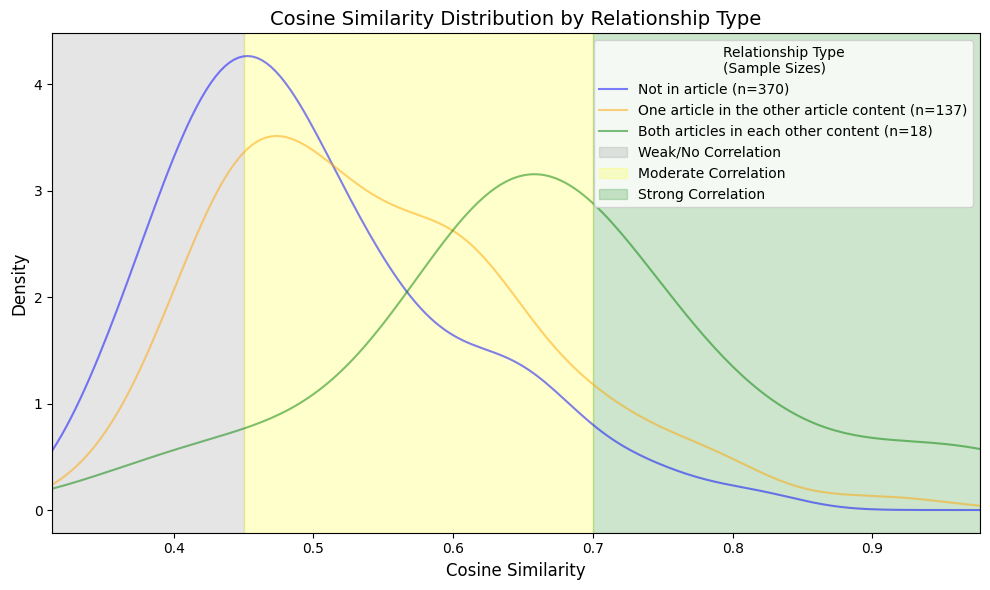

In [116]:
import matplotlib.pyplot as plt
from scipy import stats

# Creating KDE plots for semantic distances based on relationship types
plt.figure(figsize=(10, 6))

# Get counts for each relationship type
none_count = len(analysis_df[analysis_df['relationship'] == 'none'])
one_sided_count = len(analysis_df[
    (analysis_df['relationship'] == 'forward_only') | 
    (analysis_df['relationship'] == 'reverse_only')
])
both_count = len(analysis_df[analysis_df['relationship'] == 'both'])

# Define the range for plotting
distance_range = np.linspace(
    analysis_df['semantic_distance'].min(),
    analysis_df['semantic_distance'].max(),
    200
)

# Plot KDE for each relationship type
# None links
subset = analysis_df[analysis_df['relationship'] == 'none']['semantic_distance']
if len(subset) > 0:
    kde = stats.gaussian_kde(subset)
    plt.plot(distance_range, kde(distance_range), color='blue', alpha=0.5,
            label=f'Not in article (n={len(subset)})')

# One-sided links (forward or reverse)
subset = analysis_df[
    (analysis_df['relationship'] == 'forward_only') |
    (analysis_df['relationship'] == 'reverse_only')
]['semantic_distance']
if len(subset) > 0:
    kde = stats.gaussian_kde(subset)
    plt.plot(distance_range, kde(distance_range), color='orange', alpha=0.5,
            label=f'One article in the other article content (n={len(subset)})')

# One-sided links

# Both links
subset = analysis_df[analysis_df['relationship'] == 'both']['semantic_distance']
if len(subset) > 0:
    kde = stats.gaussian_kde(subset)
    plt.plot(distance_range, kde(distance_range), color='green', alpha=0.5,
            label=f'Both articles in each other content (n={len(subset)})')

# Adding title and labels
plt.title('Cosine Similarity Distribution by Relationship Type', fontsize=14)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add correlation strength regions
plt.axvspan(analysis_df['semantic_distance'].min(), 0.45, alpha=0.2, color='gray', label='Weak/No Correlation')
plt.axvspan(0.45, 0.7, alpha=0.2, color='yellow', label='Moderate Correlation')
plt.axvspan(0.7, analysis_df['semantic_distance'].max(), alpha=0.2, color='green', label='Strong Correlation')

plt.xlim(analysis_df['semantic_distance'].min(),analysis_df['semantic_distance'].max())

# Adding legend
plt.legend(title='Relationship Type\n(Sample Sizes)')

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()


In [108]:
analysis_df[['source_article', 'target_article', 'semantic_distance']].to_csv('semantic_distance_new_super_sonic_top_spiderman.csv', index=False)

In [109]:
analysis_df[analysis_df['semantic_distance'] > 0.45][['source_article', 'target_article', 'semantic_distance']].to_csv('semantic_distance_new_super_sonic_top_spiderman_strong_relation.csv', index=False)